## Training an MLP on MNIST Datset

#### Required Libraries

In [19]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax import jit, vmap, pmap, jit

#### Need to initialize MLP and parameters

In [ ]:
def init_MLP(layer_widths, scale=0.01):
    # Scale is too reduce the Standard Deviation, so that the grad doesnt explode
    params = []

    for in_width, out_width in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            [scale*np.random.randn(out_width, in_width),     # Weights
            scale*np.random.randn(out_width)]                # Bias
        )

    return params

In [10]:
# The MNIST Dataset images has 784 pixels (28*28/image)
# The output will correspond to any digit between 0-9
# Create 2 more hidden layers

MLP_params = init_MLP([784, 512, 256, 10])

#### Confirm the shape using jax.tree.map

In [11]:
print(jax.tree.map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


#### Wait! We just used NumPy -> Convert to JAX

In [12]:
def init_MLP(layer_widths, parent_key, scale=0.01):
    # Scale is too reduce the Standard Deviation, so that the grad doesnt explode
    params = []
    
    # Need to split the key into "no. of layer" parts
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, k in zip(layer_widths[:-1], layer_widths[1:], keys):
        wt_key, bias_key = jax.random.split(k)
        params.append([
            scale*jax.random.normal(wt_key, shape=(out_width, in_width)),     # Weights
            scale*jax.random.normal(bias_key, shape=(out_width,))             # Bias
        ]
        )

    return params

In [13]:
seed = 0
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)

In [14]:
print(jax.tree.map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


#### Let's now focus on the predict function

In [18]:
def MLP_predict(params, x):
    # Get all layers except the last one
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w,activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # logits is only the raw output (un-normalized)
    # logits-logsumexp(logits) ----> Basically log(Softmax)
    # logits = log(exp(op_1)), log(exp(op_2)), .....
    # subtracting logsumexp() is equivalent to dividing by sum of exp (Log Rule)
    return logits-logsumexp(logits)

In [20]:
batched_MLP_predict = vmap(MLP_predict, in_axes=(None,0))
# None since we want the parameters to be broadcast
# and 0 will be the batch dimension

#### Data Loading (PyTorch)

In [32]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import os

In [24]:
os.getcwd()

'c:\\Users\\gr8my\\Desktop\\Projects\\JAX_Basics'

In [25]:
train_dataset = MNIST(root="train_data_mnist", train=True, download=True, transform=None)
print(type(train_dataset))
print(type(train_dataset[0]))

100.0%
100.0%
100.0%
100.0%

<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>


The problem is that the image values will be PyTorch Tensors <br>
This will not work for JAX<br><br>
Therefore, we need to write a custom function

In [29]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

In [33]:
train_dataset = MNIST(root="train_data_mnist", train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root="test_data_mnist", train=False, download=True, transform=custom_transform)

In [34]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=None)

# Let's check something
batch_data = next(iter(train_loader))
print(type(batch_data))
print(type(batch_data[0]))

<class 'list'>
<class 'torch.Tensor'>


Torch Tensor again!<br>
We need a custom collate function other wise torch will convert data inside batches to Tensors again

In [35]:
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))
    labels = np.array(transposed_data[1])
    imgs = np.array(transposed_data[0])
    return imgs, labels

In [46]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)
# drop_last = True --> Since last batch may not have 128 images

In [51]:
train_imgs = jnp.array(train_dataset.data).reshape(len(train_dataset),-1)
train_labels = jnp.array(train_dataset.targets)

test_imgs = jnp.array(test_dataset.data).reshape(len(test_dataset),-1)
test_labels = jnp.array(test_dataset.targets)

#### Training Loop

In [47]:
def loss_fn(params, imgs, gt_labels):
    preds = batched_MLP_predict(params, imgs)
    # -jnp.mean(preds*gt_labels) --> will basically be softmax instead of log(softmax)
    return -jnp.mean(preds*gt_labels)

In [52]:
@jit
def update(params, imgs, gt_labels, lr=0.01):
    loss, grads = jax.value_and_grad(loss_fn)(params, imgs, gt_labels)
    return loss, jax.tree.map(lambda p,g: p-lr*g, params, grads)

In [56]:
def accuracy(params, dataset_imgs, dataset_labels):
    preds = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(preds == dataset_labels)

In [58]:
num_epochs = 5

MLP_params = init_MLP([784, 512, 256, 10], key)
for epoch in range(num_epochs):
    for batch, (imgs, labels) in enumerate(train_loader):
        gt_labels = jax.nn.one_hot(labels, len(MNIST.classes))
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
    print(f"Epoch {epoch}, Train Acc: {accuracy(MLP_params, train_imgs, train_labels):.3f}, Test Acc: {accuracy(MLP_params, test_imgs, test_labels):.3f}")

Epoch 0, Train Acc: 0.913, Test Acc: 0.919
Epoch 1, Train Acc: 0.933, Test Acc: 0.933
Epoch 2, Train Acc: 0.944, Test Acc: 0.944
Epoch 3, Train Acc: 0.955, Test Acc: 0.953
Epoch 4, Train Acc: 0.960, Test Acc: 0.957


#### Let's visualize the MLP weights

In [62]:
import matplotlib.pyplot as plt

In [61]:
w = MLP_params[0][0]
print(w.shape)

(512, 784)


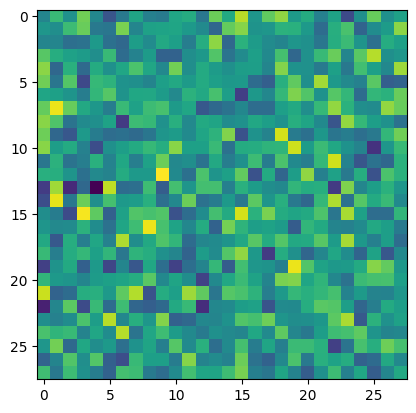

In [63]:
w_single = w[0,:].reshape((28,28))
plt.imshow(w_single)
plt.show()

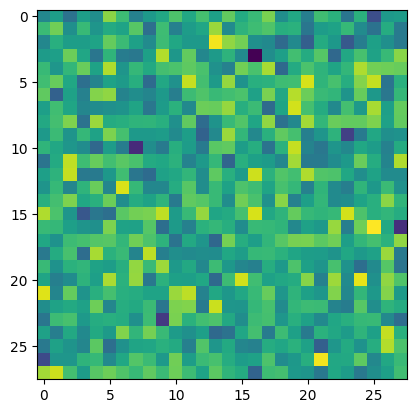

In [64]:
w_single = w[100,:].reshape((28,28))
plt.imshow(w_single)
plt.show()

#### No observable pattern or insight

#### Visualize Embedding using t-SNE

In [66]:
from sklearn.manifold import TSNE

In [67]:
def fetch_activations(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation    

In [69]:
batched_fetch_activation = vmap(fetch_activations, in_axes = (None, 0))

In [70]:
img, labels = next(iter(test_loader))
batch_activation = batched_fetch_activation(MLP_params, imgs)

KeyError: 7

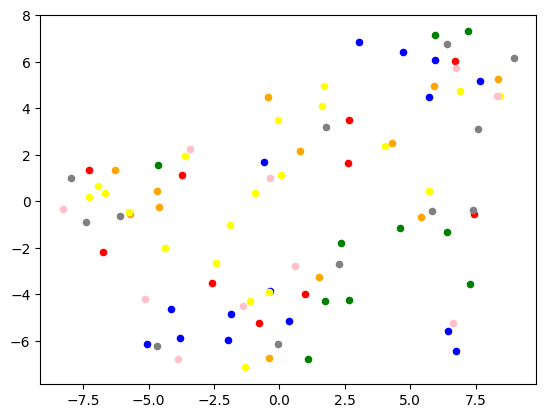

In [72]:
t_sne_embeddings = TSNE(n_components=2, perplexity=30).fit_transform(batch_activation)
cora_label_to_color_map = {0:"red", 1:"blue", 2:"green", 3:"orange", 4:"yellow", 5:"pink", 6:"gray"}
for class_id in range(10):
    plt.scatter(t_sne_embeddings[labels == class_id, 0], t_sne_embeddings[labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()